# Edge and Shortcut Analysis

This notebook provides tools for analyzing edges and shortcuts data.

In [13]:
import pandas as pd
import numpy as np
import h3
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt

# Load data
edges = pd.read_csv('../data/Somerset_driving_simplified_edges_with_h3.csv')
shortcuts = pd.read_parquet('../output/Somerset_shortcuts')
graph = pd.read_csv('../data/Somerset_driving_edge_graph.csv')

# Add cost to edges
edges['cost'] = edges['length'] / edges['maxspeed'].replace(0, np.inf)

print(f'Edges: {len(edges):,}')
print(f'Shortcuts: {len(shortcuts):,}')
print(f'Edge graph connections: {len(graph):,}')

Edges: 5,900
Shortcuts: 378,141
Edge graph connections: 16,301


## Edge Analysis

In [14]:
# Edge statistics
print('=== Edge Statistics ===')
print(f'Total edges: {len(edges):,}')
print(f'\nlca_res distribution:')
print(edges['lca_res'].value_counts().sort_index())
print(f'\nHighway types:')
print(edges['highway'].value_counts().head(10))

=== Edge Statistics ===
Total edges: 5,900

lca_res distribution:
lca_res
-1      213
 5       36
 6       99
 7      398
 8      906
 9     1474
 10    1598
 11     982
 12     182
 13      12
Name: count, dtype: int64

Highway types:
highway
service                         2695
residential                     2053
secondary                        401
unclassified                     277
primary                          208
tertiary                         115
trunk                             75
['residential', 'service']        16
['residential', 'secondary']      12
trunk_link                        12
Name: count, dtype: int64


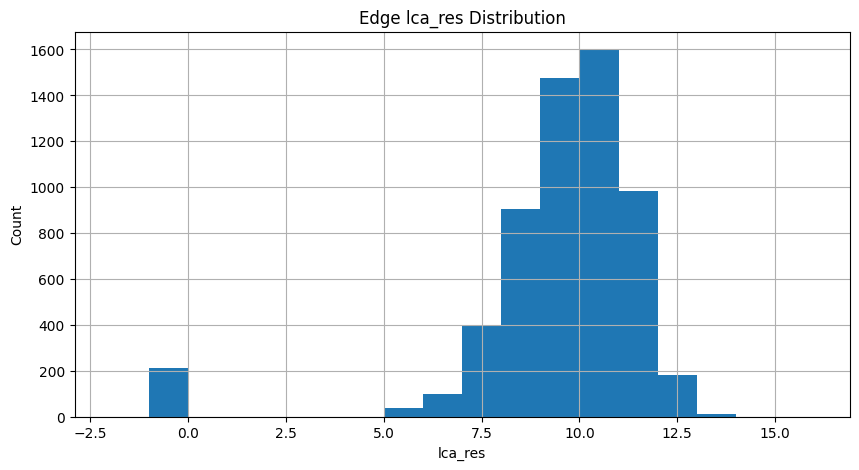

In [15]:
# Edge lca_res histogram
plt.figure(figsize=(10, 5))
edges['lca_res'].hist(bins=range(-2, 17))
plt.xlabel('lca_res')
plt.ylabel('Count')
plt.title('Edge lca_res Distribution')
plt.show()

## Shortcut Analysis

In [16]:
# Shortcut statistics
print('=== Shortcut Statistics ===')
print(f'Total shortcuts: {len(shortcuts):,}')
print(f'\ninside value distribution:')
print(shortcuts['inside'].value_counts().sort_index())
print(f'\nPercentage breakdown:')
for val in sorted(shortcuts['inside'].unique()):
    count = (shortcuts['inside'] == val).sum()
    pct = 100 * count / len(shortcuts)
    label = {-2: 'outer-only', -1: 'downward', 0: 'lateral', 1: 'upward'}.get(val, str(val))
    print(f'  inside={val:2d} ({label:10s}): {count:>8,} ({pct:5.1f}%)')

=== Shortcut Statistics ===
Total shortcuts: 378,141

inside value distribution:
inside
-2    130359
-1     65119
 0    117090
 1     65573
Name: count, dtype: int64

Percentage breakdown:
  inside=-2 (outer-only):  130,359 ( 34.5%)
  inside=-1 (downward  ):   65,119 ( 17.2%)
  inside= 0 (lateral   ):  117,090 ( 31.0%)
  inside= 1 (upward    ):   65,573 ( 17.3%)


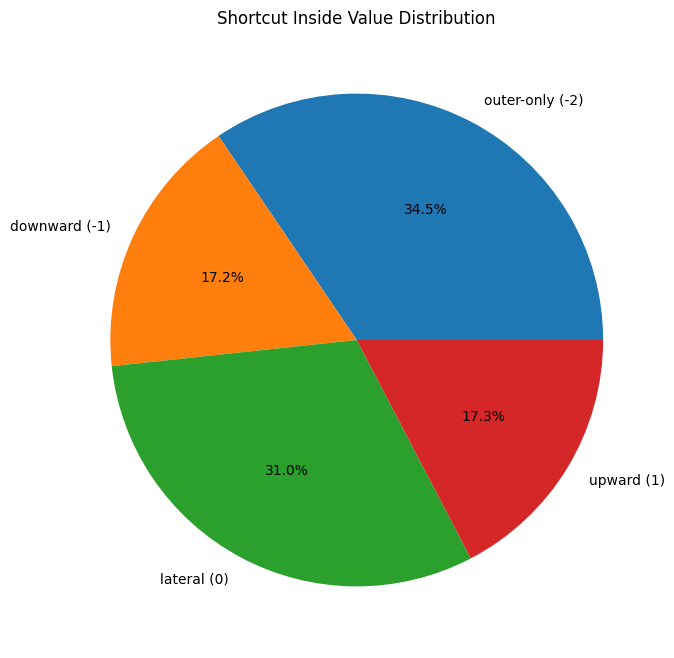

In [17]:
# Inside value pie chart
plt.figure(figsize=(8, 8))
inside_counts = shortcuts['inside'].value_counts().sort_index()
labels = {-2: 'outer-only (-2)', -1: 'downward (-1)', 0: 'lateral (0)', 1: 'upward (1)'}
plt.pie(inside_counts.values, labels=[labels[i] for i in inside_counts.index], autopct='%1.1f%%')
plt.title('Shortcut Inside Value Distribution')
plt.show()

## Optimality Verification

In [18]:
# Build graph for shortest path verification
edge_costs = edges.set_index('id')['cost'].to_dict()
graph['cost'] = graph['incoming_edge'].map(edge_costs)

all_edges = pd.concat([graph['incoming_edge'], graph['outgoing_edge']]).unique()
edge_to_idx = {e: i for i, e in enumerate(all_edges)}
n = len(all_edges)

src = graph['incoming_edge'].map(edge_to_idx).values
dst = graph['outgoing_edge'].map(edge_to_idx).values
costs = graph['cost'].values
matrix = csr_matrix((costs, (src, dst)), shape=(n, n))

print('Computing true shortest paths...')
dist_matrix = shortest_path(csgraph=matrix, method='auto', directed=True)
print('Done!')

Computing true shortest paths...
Done!


In [19]:
# Verify shortcuts
shortcuts['src_idx'] = shortcuts['incoming_edge'].map(edge_to_idx)
shortcuts['dst_idx'] = shortcuts['outgoing_edge'].map(edge_to_idx)
shortcuts['true_cost'] = [dist_matrix[s, d] for s, d in zip(shortcuts['src_idx'], shortcuts['dst_idx'])]
shortcuts['diff'] = np.abs(shortcuts['cost'] - shortcuts['true_cost'])
shortcuts['is_optimal'] = shortcuts['diff'] < 1e-6

print('=== Optimality Check ===')
opt_count = shortcuts['is_optimal'].sum()
total = len(shortcuts)
print(f'Optimal: {opt_count:,} / {total:,} ({100*opt_count/total:.2f}%)')

non_optimal = shortcuts[~shortcuts['is_optimal']]
print(f'Non-optimal: {len(non_optimal):,}')

if len(non_optimal) > 0:
    print('\nSample non-optimal shortcuts:')
    print(non_optimal[['incoming_edge', 'outgoing_edge', 'cost', 'true_cost', 'diff']].head(10))

=== Optimality Check ===
Optimal: 378,141 / 378,141 (100.00%)
Non-optimal: 0


## Lookup Functions

In [20]:
# Create lookup dictionaries
edge_info = edges.set_index('id').to_dict('index')

def find_lca(cell1, cell2):
    """Find LCA of two H3 cells."""
    c1 = h3.int_to_str(cell1)
    c2 = h3.int_to_str(cell2)
    for res in range(min(h3.get_resolution(c1), h3.get_resolution(c2)), -1, -1):
        if h3.cell_to_parent(c1, res) == h3.cell_to_parent(c2, res):
            return h3.str_to_int(h3.cell_to_parent(c1, res)), res
    return 0, -1

def get_edge_info(edge_id):
    """Get detailed info for an edge."""
    if edge_id not in edge_info:
        return None
    e = edge_info[edge_id]
    return {
        'id': edge_id,
        'lca_res': e['lca_res'],
        'cost': e['cost'],
        'A.from': e['outgoing_cell'],
        'A.to': e['incoming_cell'],
    }

def get_shortcut_info(a, b):
    """Get detailed info for a shortcut."""
    match = shortcuts[(shortcuts['incoming_edge'] == a) & (shortcuts['outgoing_edge'] == b)]
    if len(match) == 0:
        return None
    s = match.iloc[0]
    
    e_a = edge_info[a]
    e_b = edge_info[b]
    
    a_to = e_a['incoming_cell']
    a_from = e_a['outgoing_cell']
    b_to = e_b['incoming_cell']
    b_from = e_b['outgoing_cell']
    
    lca_res = max(e_a['lca_res'], e_b['lca_res'])
    inner_cell, inner_res = find_lca(a_to, b_from)
    outer_cell, outer_res = find_lca(a_from, b_to)
    true_cost = dist_matrix[edge_to_idx[a], edge_to_idx[b]]
    
    return {
        'shortcut': f'{a}→{b}',
        'cost': s['cost'],
        'true_cost': true_cost,
        'optimal': abs(s['cost'] - true_cost) < 1e-6,
        'via_edge': int(s['via_edge']),
        'inside': int(s['inside']),
        'lca_res': lca_res,
        'inner_res': inner_res,
        'outer_res': outer_res,
    }

print('Lookup functions defined: get_edge_info(edge_id), get_shortcut_info(a, b)')

Lookup functions defined: get_edge_info(edge_id), get_shortcut_info(a, b)


In [21]:
# Example usage
print('=== Example: Edge 2 ===')
print(get_edge_info(2))

print('\n=== Example: Shortcut 2→71 ===')
print(get_shortcut_info(2, 71))

=== Example: Edge 2 ===
{'id': 2, 'lca_res': 8, 'cost': 6.462079999999999, 'A.from': 645224977383611141, 'A.to': 645224977384658840}

=== Example: Shortcut 2→71 ===
{'shortcut': '2→71', 'cost': np.float64(59.40626428571428), 'true_cost': np.float64(59.406264285714286), 'optimal': np.True_, 'via_edge': 3059, 'inside': -2, 'lca_res': 8, 'inner_res': 7, 'outer_res': 8}


## Custom Analysis

Use the cells below for your own analysis.

In [22]:
# Your analysis here
